# Define and run pipelines

In Notebook 2 we learn pipelines. Pipeline is a sequence of actions we want to apply to [batch](https://github.com/analysiscenter/ecg/blob/unify_models/doc/batch.md). At first we describe what we want to do with batch. Then at some point in our code we pass dataset to pipeline and calculations actually run.

## Define pipeline

The following example shows how to define a pipeline. It simply lists actions:
* load data
* resample signal to new fs
* drop signals that are too short
* generate segments with specified length and step size from signal
* save result in optimized format [blosc](http://blosc.org/).

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio.batch import EcgBatch

path_to_dump = '/notebooks/e_illarionov/ecg_repo/signal_dump/'

preprocess_pipeline = (ds.Pipeline()
                       .load(fmt="wfdb", components=["signal", "meta"])
                       .random_resample_signals("normal", loc=300, scale=10)
                       .drop_short_signals(4000)
                       .split_signals(3000, 3000)
                       .dump(fmt='blosc', dst=path_to_dump))

Using TensorFlow backend.


Note that when we run pipeline batches will be generated and __destroyed__ inside the pipeline. To have access to processed data we include ```dump``` action. This action is unnecessary e.g. in model training. The other options is to save result to pipeline variable. See [here](https://github.com/analysiscenter/dataset/blob/master/doc/pipeline.md) more features of pipelines.

## Run pipeline

Let's create an ECG dataset that will be passed to the pipeline (see [Notebook 1](https://github.com/analysiscenter/ecg/blob/unify_models/doc/ecg_tutorial_part_1.ipynb) for dataset): 

In [2]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=EcgBatch)

To start calculation we pass ECG dataset into the pipeline and call an action ```run```. It will iterate over dataset with given batch size until no ECGs are left:

In [3]:
(eds >> preprocess_pipeline).run(batch_size=300, shuffle=False, drop_last=False, n_epochs=1)

As a result we obtain dump of processed ECGs located in folder ```path_to_dump```.

## Add custom action

Suppose you want to include in pipeline a new action called ```add_value``` that adds given value to each signal. Any new action should be defined in ```Batch``` and have decorator ```@action```.

To demonstrate how it works let's create a new class ```MyEcgBatch``` with ```EcgBatch``` class as parent. In ```MyEcgBatch``` we define method  ```add_value``` and decorate it with ```@action```. We add also optional decorator ```@inbatch_parallel``` that splits batch into individual ECGs and process each ECG in a separate thread. Being decorated ```add_value``` obtains index of ECG and every parameter passed from pipeline. From index it obtains position of corresponding signal in batch and adds value to the signal. Let's combine it all together:

In [4]:
class MyEcgBatch(EcgBatch):  # pylint: disable=too-many-public-methods
    """Class for storing batch of ECG signals."""

    def __init__(self, index, preloaded=None, unique_labels=None):
        super().__init__(index, preloaded, unique_labels)

    @ds.action
    @ds.inbatch_parallel(init="indices", target="threads")
    def add_value(self, index, value):
        i = self.get_pos(None, "signal", index)
        self.signal[i] += value

Let's apply ```add_value``` to some batch and check the effect. Create new batch with data:

In [5]:
eds = ds.Dataset(index, batch_class=MyEcgBatch)
batch = eds.next_batch(100)
batch_with_data = batch.load(fmt="wfdb", components=["signal", "meta"])

Remember some signal from batch:

In [6]:
ecg_id = 'A00012'
original_signal = batch_with_data[ecg_id].signal.copy()

Apply ```add_value``` with value -1 to batch:

In [7]:
batch_transformed = batch_with_data.add_value(-1)

Compare results:

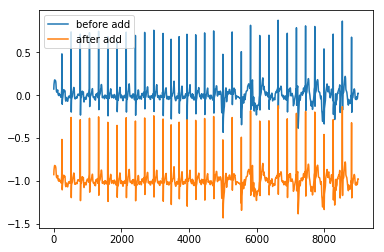

In [8]:
transformed_signal = batch_transformed[ecg_id].signal

import matplotlib.pyplot as plt
plt.plot(original_signal.ravel(), label='before add')
plt.plot(transformed_signal.ravel(), label='after add')
plt.legend()
plt.show()

Now we can include ```add_value``` in pipeline:

In [9]:
preprocess_pipeline = (ds.Pipeline()
                       .load(fmt="wfdb", components=["signal", "meta"])
                       .random_resample_signals("normal", loc=300, scale=10)
                       .drop_short_signals(4000)
                       .split_signals(3000, 3000)
                       .add_value(-1)
                       .dump(fmt='blosc', dst=path_to_dump))

Run modified pipeline:

In [10]:
(eds >> preprocess_pipeline).run(batch_size=300, shuffle=False, drop_last=False, n_epochs=1)

Summarizing, in Notebook 2 we learned:
* how to construct and run pipelines
* how to add custom actions.

In the next [Notebook 3](https://github.com/analysiscenter/ecg/blob/unify_models/doc/ecg_tutorial_part_3.ipynb) we will work with models.